In [1]:
import os, sys
sys.path.append("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1,"
from pathlib import Path
from types import SimpleNamespace
import math, json
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from einops import rearrange
from PIL import Image, ImageDraw, ImageOps
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model, attn_cache
from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights
from preproc_utils import get_text_preproc, getres, preproc_image, preproc_mask, prepare_image_inputs, prepare_control_inputs

sys.path.append("/data/whisperer/utils")
from img_utils import convert_from_qwen2vl_format
from vistory_utils import StoryDataset

device = torch.device('cuda')
lt.monkey_patch()

2025-08-01 19:41:05.074888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754044865.094071  163049 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754044865.099971  163049 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 19:41:05.123355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
lora_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors"
# lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/s2vnexus_posecontrol_lora/lora_test3.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)

merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], lora_multiplier = [1.0], 
        include_patterns=None, exclude_patterns=None, lycoris=None,
        save_merged_model=False
    ), 
device, None)
target_index = [1]
control_indices = [0,10]

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (8

In [16]:
# prompt = 'An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance.'
# height, width = 480, 480

# control_image_paths = ["docs/bg_sample.png", "docs/fg_sample.jpg"]
# control_image_mask_paths = ["", ""]

# image_paths = ["docs/bg_sample.png"]
# entity_prompts = ["An anime-style girl wearing a school uniform and ribbon tie"]
# entity_masks = ["docs/bg_sample_mask.png", 'docs/bg_sample_mask_inverted.png']

prompt = 'Chinese Ancient Wuxia. The red-clothed maiden and the burly man engage in a fierce battle on the stage. The surrounding crowd cheers excitedly.'
entity_prompts = ["red-clothed maiden"]
entity_mask_paths = [
    "../../outputs/vistory_tmp/vistory_04_04_mask_bg.png", 
    "../../outputs/vistory_tmp/vistory_04_04_mask_fg.png"
]

height, width = 336, 672

image_paths = ["../../outputs/vistory_tmp/vistory_04_04_bg.png"]
control_image_paths = [
    "../../outputs/vistory_tmp/vistory_04_04_bg.png", 
    "/data/whisperer/datasets/storyviz/ViStoryBench/ViStoryBench/04/image/Red-Clothed Maiden/00.jpg"
    # "../../outputs/vistory_tmp/vistory_04_04_chara.png"
]
control_image_mask_paths = ["", ""]

In [17]:
## Text Preprocessing
text_kwargs = get_text_preproc(prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, entity_prompts=entity_prompts, device=device)

## Image Preprocessing
image_kwargs, img_np = prepare_image_inputs(
    image_paths, feature_extractor, image_encoder, 
    width=width, height=height, 
    target_index=target_index, device=device, dtype=torch.bfloat16)

## Control Preprocessing
control_image_paths[0] = Image.open(control_image_paths[0]).resize((width, height))
# control_image_paths[1] = Image.open(control_image_paths[1]).resize((256, 256))

control_kwargs, control_nps = prepare_control_inputs(
    control_image_paths, control_image_mask_paths, vae,
    # width=None, height=None, 
    width=width, height=height,
    control_indices=control_indices)

entity_masks = torch.cat([preproc_mask(e_mask, width, height, invert=False)[0] for e_mask in entity_mask_paths], 1)

In [5]:
# width, height = None, None
# control_latents, control_nps = [], []
# for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
#     c_img_tensor, c_img_np = preproc_image(control_image_path, width, height)
#     print(c_img_tensor)
#     c_H, c_W = c_img_tensor.shape[-2:]
#     c_img_latent = vae_encode(c_img_tensor, vae).cpu()
#     print(c_img_latent)
#     c_mask_image, c_mask_np = preproc_mask(control_mask_path, c_W, c_H)
#     print(c_mask_image)
#     c_img_latent = c_img_latent * c_mask_image
#     control_latents.append(c_img_latent)
#     control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (c_W, c_H))[..., None]], -1))
# # clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)
# clean_latents = control_latents
# clean_latent_indices = [torch.tensor([[ind]], dtype=torch.int64) for ind in control_indices]

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 2646, 3072] bf16 n=8128512 (16Mb) x∈[-15.625, 18.125] μ=-0.025 σ=1.211 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 769, 3072] bf16 n=2362368 (4.5Mb) x∈[-2.976e+03, 2.560e+03] μ=0.354 σ=152.000 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-8.312, 19.000] μ=-0.102 σ=0.914 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 3415, 3415] bf16 n=11662225 (22Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 2646, 256] n=677376 (2.6Mb) x∈[-1.000, 1.000] μ=0.371 σ=0.602 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'clean_latents': [(0, 882), (882, 1764)], 'noise': [(1764, 2646)], 'image_embeddings': [(2646, 3375)], 'text_embeddings': [(3375, 3409), (3409, 3415)]})
/data/whisperer/related/framepackbase/musubi-tuner/src/practice/../musubi_tuner/frame_pack/hunyuan_video_packed.py:794: UserWarning: You are using Attention Mask, but sageattn does no

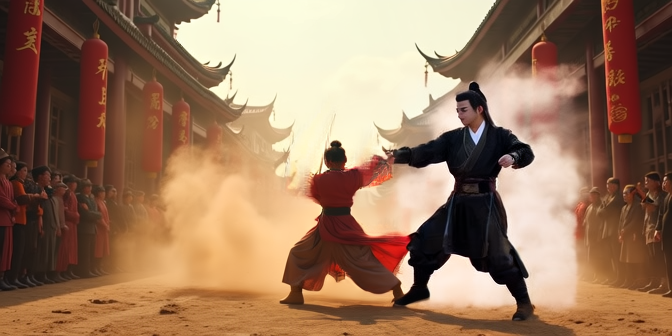

In [18]:
num_inference_steps=25
seed = np.random.randint(2**31)
# seed = 2105350387 1989424941
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

attn_cache.clear()
results = sample_hunyuan(
    transformer=model, sampler='unipc', width=width, height=height, frames=1, batch_size=1,
    real_guidance_scale=1.0, distilled_guidance_scale=10.0, guidance_rescale=0.0, shift=None,
    num_inference_steps=num_inference_steps,
    generator=generator, device=device, dtype=torch.bfloat16,
    cache_results=True, cache_layers = [], 
    clean_latent_bbox=None,
    use_attention_masking=["no_cross_control_latents", "mask_entities", "mask_control"],
    entity_masks=entity_masks,
    **text_kwargs, 
    **image_kwargs,
    **control_kwargs
)
history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)
result_img = np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)

# Image.fromarray(np.concatenate(control_nps + [result_img], axis=1))
Image.fromarray(result_img)

defaultdict(<class 'list'>, {'clean_latents': [(0, 882), (882, 1764)], 'noise': [(1764, 2646)], 'image_embeddings': [(2646, 3375)], 'text_embeddings': [(3375, 3409), (3409, 3415)]})


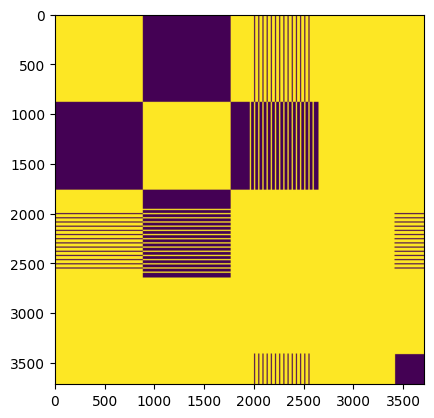

In [ ]:
print(attn_cache['attn_dict'])
attn_mask = attn_cache['attn_mask'].clone()
attn_mask[attn_mask > -9999.] = 1
attn_mask[attn_mask < -9999.] = 0
attn_mask = attn_mask.bool().cpu().numpy()[0]

# attn_mask_2 = np.zeros((attn_mask.shape[0]+300,attn_mask.shape[1]+300), dtype=bool)
# attn_mask_2[:attn_mask.shape[0],:attn_mask.shape[1]] = attn_mask
# attn_mask_2[attn_mask.shape[0]:attn_mask.shape[0]+300,:attn_mask.shape[1]] = attn_mask[attn_cache['attn_dict']['text_embeddings'][1][0]:attn_cache['attn_dict']['text_embeddings'][1][1]].repeat(50, 0)
# attn_mask_2[:attn_mask.shape[0],attn_mask.shape[1]:attn_mask.shape[1]+300] = attn_mask[attn_cache['attn_dict']['text_embeddings'][1][0]:attn_cache['attn_dict']['text_embeddings'][1][1]].repeat(50, 0).T

plt.imshow(attn_mask)

In [ ]:
# weights_sd = load_file(lora_path)
# network = lora_framepack.create_arch_network_from_weights(1.0, weights_sd, unet=model, for_inference=True)
# network.merge_to(None, model, weights_sd, device=device, non_blocking=True)
# torch.cuda.synchronize()